In [1]:
import torch
from basic_unet import UNet
from dataset import load_dataset
from plot_utils import plot_image_row
from torchvision import transforms
from dataset import BratsDataset
from hausdorff_distance_masks import HausdorffDistanceMasks
from pathlib import Path
from IPython.core.display import HTML, display

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset(batch_size=1)
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

In [3]:
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
])
dataset = BratsDataset(Path('data/processed/'), transform)
sample = dataset.get_sample('Brats18_TCIA08_242_1/', 'L2')
segment = sample['segment']
segment = segment.squeeze()

image = sample['input'].unsqueeze(0)
image = image.to(device)

output = model(image)
output = output.detach().cpu().squeeze().numpy()

In [4]:
hdm = HausdorffDistanceMasks(240, 240)
hdm.generate_masks(circle_size=15, offset=5, normalize=True)

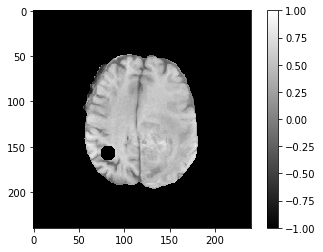

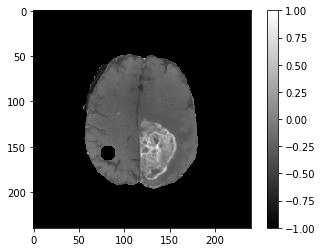

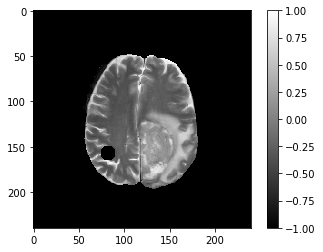

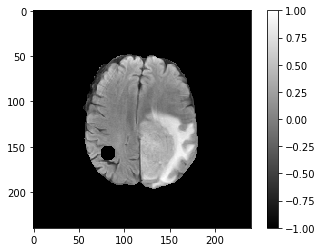

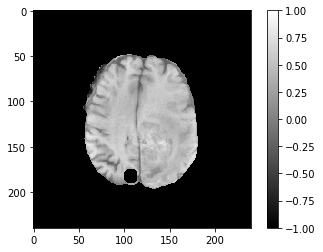

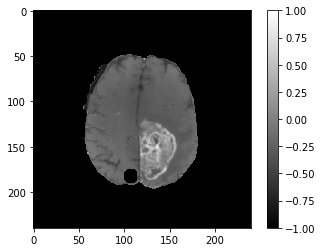

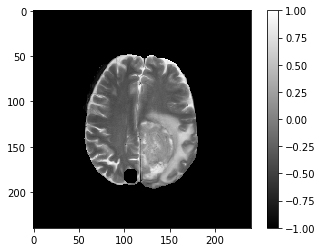

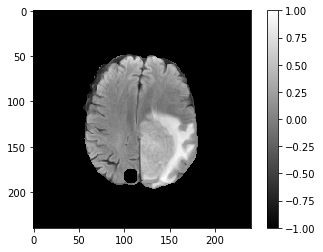

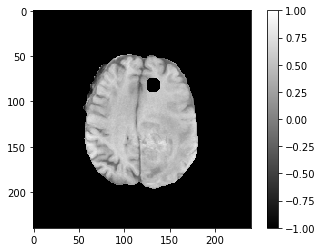

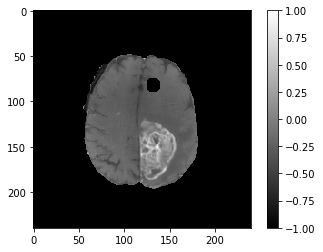

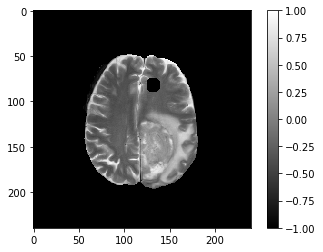

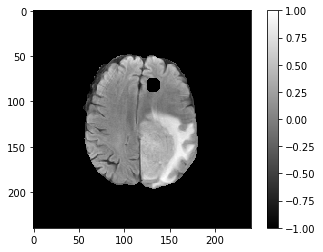

In [5]:
offsets = [
    (15, 30),
    (20, 35),
    (25, 15),
]
for y_offset, x_offset in offsets:
    display(HTML(f'<h2>x {x_offset}, y: {y_offset}</h2>'))
    mask = hdm.masks[x_offset][y_offset]
    mask = mask.to(device)
    masked_image = torch.min(image, mask)
    masked_image = masked_image.cpu()[0]

    plot_image_row([masked_image[0]], color_map='gray', colorbar=True)
    plot_image_row([masked_image[1]], color_map='gray', colorbar=True)
    plot_image_row([masked_image[2]], color_map='gray', colorbar=True)
    plot_image_row([masked_image[3]], color_map='gray', colorbar=True)